### This code illustrates the learning algorithm for Dense Associative Memories from [Dense Associative Memory for Pattern Recognition](https://arxiv.org/abs/1606.01164) on MNIST data set.
If you want to learn more about Dense Associative Memories, check out a [NIPS 2016 talk](https://channel9.msdn.com/Events/Neural-Information-Processing-Systems-Conference/Neural-Information-Processing-Systems-Conference-NIPS-2016/Dense-Associative-Memory-for-Pattern-Recognition) or a [research seminar](https://www.youtube.com/watch?v=lvuAU_3t134). 

This cell loads the data and normalizes it to the [-1,1] range

To draw a heatmap of the weights together with the errors on the training set (blue) and the test set (red) a helper function is created:

This cell defines parameters of the algorithm: `n` - power of the rectified polynomial in [Eq 3](https://arxiv.org/abs/1606.01164); `m` - power of the loss function in [Eq 14](https://arxiv.org/abs/1606.01164); `K` - number of memories that are displayed as an `Ky` by `Kx` array by the helper function defined above; `eps0` - initial learning rate that is exponentially annealed during training with the damping parameter `f`, as explained in [Eq 12](https://arxiv.org/abs/1606.01164); `p` - momentum as defined in [Eq 13](https://arxiv.org/abs/1606.01164); `mu` - the mean of the gaussian distribution that initializes the weights; `sigma` - the standard deviation of that gaussian; `Nep` - number of epochs; `Num` - size of the training minibatch; `NumT` - size of the test minibatch; `prec` - parameter that controls numerical precision of the weight updates. Parameter `beta` that is used in [Eq 9](https://arxiv.org/abs/1606.01164) is defined as `beta=1/Temp**n`. The choice of temperatures `Temp` as well as the duration of the annealing `thresh_pret` is discussed in [Appendix A](https://arxiv.org/abs/1606.01164). 

Kx=10              # Number of memories per row on the weights plot
Ky=10              # Number of memories per column on the weigths plot
K=Kx*Ky            # Number of memories
n=20               # Power of the interaction vertex in the DAM energy function
m=30               # Power of the loss function
eps0=4.0e-2        # Initial learning rate  
f=0.998            # Damping parameter for the learning rate
p=0.6              # Momentum
Nep=300            # Number of epochs
Temp_in=540.       # Initial temperature
Temp_f=540.        # Final temperature
thresh_pret=200    # Length of the temperature ramp
Num=1000           # Size of training minibatch     
NumT=5000          # Size of test minibatch 
mu=-0.3            # Weights initialization mean
sigma=0.3          # Weights initialization std
prec=1.0e-30       # Precision of weight update

This cell defines the main code. The external loop runs over epochs `nep`, the internal loop runs over minibatches.  The weights are updated after each minibatch in a way so that the largest update is equal to the learning rate `eps` at that epoch, see [Eq 13](https://arxiv.org/abs/1606.01164). The weights are displayed by the helper function after each epoch. 

In [32]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Load MNIST dataset
mat = scipy.io.loadmat('mnist_all.mat')

N = 784    # Input dimension (28x28 pixels)
Nc = 10    # Number of classes (digits 0-9)
samples_per_class = 5000  # Number of samples per class for training
test_samples_per_class = 800  # Number of samples per class for testing

# Process training data
M = np.zeros((0,N))
Lab = np.zeros((Nc,0))
for i in range(Nc):
    # Take only first 5000 samples from each class
    class_data = mat['train'+str(i)][:samples_per_class]
    M = np.concatenate((M, class_data), axis=0)
    # Create one-vs-all labels (-1,1 encoding)
    lab1 = -np.ones((Nc, samples_per_class))
    lab1[i,:] = 1.0
    Lab = np.concatenate((Lab, lab1), axis=1)

# Normalize to [-1,1] range and transpose
M = 2*M/255.0-1
M = M.T

# Process test data
MT = np.zeros((0,N))
LabT = np.zeros((Nc,0))
for i in range(Nc):
    # Take only first 900 samples from each class for testing
    class_data = mat['test'+str(i)][:test_samples_per_class]
    MT = np.concatenate((MT, class_data), axis=0)
    # Create one-vs-all labels (-1,1 encoding)
    lab1 = -np.ones((Nc, test_samples_per_class))
    lab1[i,:] = 1.0
    LabT = np.concatenate((LabT, lab1), axis=1)

# Normalize to [-1,1] range and transpose
MT = 2*MT/255.0-1
MT = MT.T

# Print data integrity information
print(f"Total training samples: {M.shape[1]}")
print(f"Total test samples: {MT.shape[1]}")
print(f"Feature dimension: {M.shape[0]}")
print(f"Number of classes: {Lab.shape[0]}")

Total training samples: 50000
Total test samples: 8000
Feature dimension: 784
Number of classes: 10


Total training samples: 50000 (should be 50000)
Total test samples: 8992 (should be 9000)
Feature dimension: 784 (should be 784)
Number of classes: 10 (should be 10)


Training K=50: 100%|██████████| 300/300 [06:26<00:00,  1.29s/it]


K=50: α=0.4420, Test Acc=0.4292


Training K=100: 100%|██████████| 300/300 [09:37<00:00,  1.93s/it]


K=100: α=0.6384, Test Acc=0.6430


Training K=150: 100%|██████████| 300/300 [12:34<00:00,  2.52s/it]


K=150: α=0.6489, Test Acc=0.6521


Training K=200: 100%|██████████| 300/300 [15:09<00:00,  3.03s/it]


K=200: α=0.7553, Test Acc=0.7655


Training K=250: 100%|██████████| 300/300 [17:35<00:00,  3.52s/it]


K=250: α=0.7624, Test Acc=0.7787


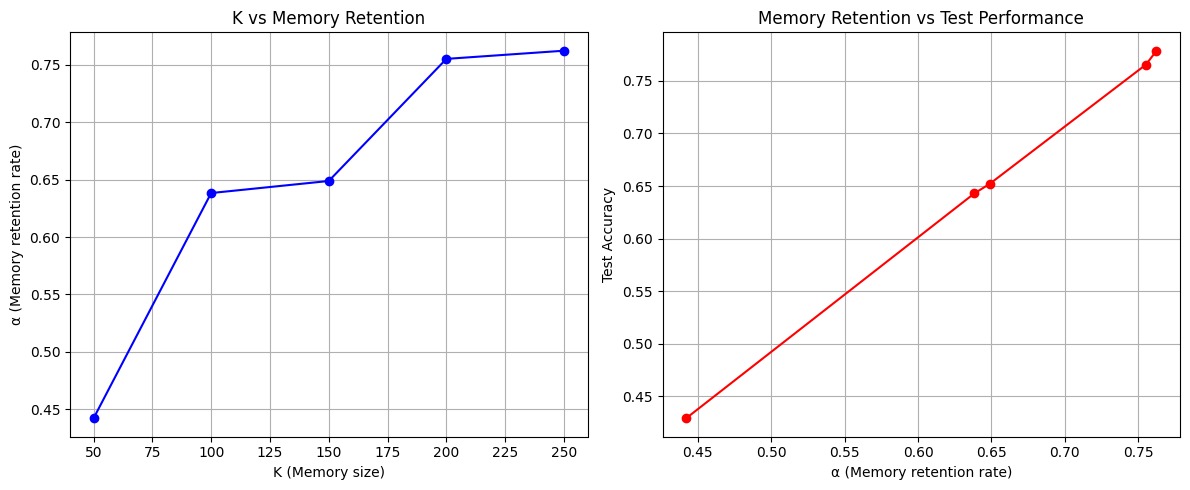

In [33]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Load and prepare data
def prepare_data(samples_per_class=5000, test_samples_per_class=900):
    """
    Prepare fixed-size training and test sets from MNIST
    """
    mat = scipy.io.loadmat('mnist_all.mat')
    N = 784    # Input dimension
    Nc = 10    # Number of classes

    # Process training data
    M = np.zeros((0,N))
    Lab = np.zeros((Nc,0))
    for i in range(Nc):
        class_data = mat['train'+str(i)][:samples_per_class]
        M = np.concatenate((M, class_data), axis=0)
        lab1 = -np.ones((Nc, samples_per_class))
        lab1[i,:] = 1.0
        Lab = np.concatenate((Lab, lab1), axis=1)
    M = 2*M/255.0-1
    M = M.T

    # Process test data
    MT = np.zeros((0,N))
    LabT = np.zeros((Nc,0))
    for i in range(Nc):
        class_data = mat['test'+str(i)][:test_samples_per_class]
        MT = np.concatenate((MT, class_data), axis=0)
        lab1 = -np.ones((Nc, test_samples_per_class))
        lab1[i,:] = 1.0
        LabT = np.concatenate((LabT, lab1), axis=1)
    MT = 2*MT/255.0-1
    MT = MT.T

    print(f"Total training samples: {M.shape[1]} (should be {Nc*samples_per_class})")
    print(f"Total test samples: {MT.shape[1]} (should be {Nc*test_samples_per_class})")
    print(f"Feature dimension: {M.shape[0]} (should be {N})")
    print(f"Number of classes: {Lab.shape[0]} (should be {Nc})")
    
    return M, Lab, MT, LabT

def train_and_evaluate(K, M_train, Lab_train, MT, LabT, params):
    """
    Train DAM model and evaluate its performance
    """
    N = M_train.shape[0]
    Nc = Lab_train.shape[0]
    Num = params['Num']
    
    # Initialize weights
    KS = np.random.normal(params['mu'], params['sigma'], (K, N+Nc))
    VKS = np.zeros((K, N+Nc))
    
    # Prepare auxiliary matrix for labels
    aux = -np.ones((Nc, Num*Nc))
    for d in range(Nc):
        aux[d,d*Num:(d+1)*Num] = 1.
    
    # Training loop
    for nep in tqdm(range(params['Nep']), desc=f"Training K={K}"):
        eps = params['eps0'] * params['f']**nep
        
        # Temperature scheduling
        if nep <= params['thresh_pret']:
            Temp = params['Temp_in'] + (params['Temp_f']-params['Temp_in'])*nep/params['thresh_pret']
        else:
            Temp = params['Temp_f']
        beta = 1./Temp**params['n']
        
        # Shuffle training data
        perm = np.random.permutation(M_train.shape[1])
        M_train = M_train[:,perm]
        Lab_train = Lab_train[:,perm]
        
        num_correct = 0
        # Mini-batch training
        for k in range(M_train.shape[1]//Num):
            # Prepare batch data
            v = M_train[:,k*Num:(k+1)*Num]
            t_R = Lab_train[:,k*Num:(k+1)*Num]
            t = np.reshape(t_R,(1,Nc*Num))
            
            # Forward pass
            u = np.concatenate((v, -np.ones((Nc,Num))), axis=0)
            uu = np.tile(u,(1,Nc))
            vv = np.concatenate((uu[:N,:],aux),axis=0)
            
            KSvv = np.maximum(np.dot(KS,vv),0)
            KSuu = np.maximum(np.dot(KS,uu),0)
            Y = np.tanh(beta*np.sum(KSvv**params['n']-KSuu**params['n'], axis=0))
            Y_R = np.reshape(Y,(Nc,Num))
            
            # Compute gradients and update weights
            d_KS = np.dot(np.tile((t-Y)**(2*params['m']-1)*(1-Y)*(1+Y), (K,1))*KSvv**(params['n']-1),vv.T) - \
                   np.dot(np.tile((t-Y)**(2*params['m']-1)*(1-Y)*(1+Y), (K,1))*KSuu**(params['n']-1),uu.T)
            
            VKS = params['p']*VKS + d_KS
            nc = np.amax(np.absolute(VKS),axis=1).reshape(K,1)
            nc[nc<params['prec']] = params['prec']
            ncc = np.tile(nc,(1,N+Nc))
            KS += eps*VKS/ncc
            KS = np.clip(KS, a_min=-1., a_max=1.)
            
            correct = np.argmax(Y_R,axis=0) == np.argmax(t_R,axis=0)
            num_correct += np.sum(correct)
    
    # Compute final metrics
    train_recovery = evaluate_recovery(KS, M_train, Lab_train, params)
    test_acc = evaluate_recovery(KS, MT, LabT, params)
    
    return train_recovery, test_acc

def evaluate_recovery(KS, data, labels, params):
    """
    Evaluate model's recovery rate on given dataset
    """
    N = data.shape[0]
    Nc = labels.shape[0]
    Num = params['Num']
    num_correct = 0
    
    beta = 1./params['Temp_f']**params['n']
    aux = -np.ones((Nc, Num*Nc))
    for d in range(Nc):
        aux[d,d*Num:(d+1)*Num] = 1.
    
    for k in range(data.shape[1]//Num):
        v = data[:,k*Num:(k+1)*Num]
        t_R = labels[:,k*Num:(k+1)*Num]
        
        u = np.concatenate((v, -np.ones((Nc,Num))), axis=0)
        uu = np.tile(u,(1,Nc))
        vv = np.concatenate((uu[:N,:],aux),axis=0)
        
        KSvv = np.maximum(np.dot(KS,vv),0)
        KSuu = np.maximum(np.dot(KS,uu),0)
        Y = np.tanh(beta*np.sum(KSvv**params['n']-KSuu**params['n'], axis=0))
        Y_R = np.reshape(Y,(Nc,Num))
        
        correct = np.argmax(Y_R,axis=0) == np.argmax(t_R,axis=0)
        num_correct += np.sum(correct)
    
    return num_correct / (data.shape[1]//Num * Num)

def main():
    # Load data
    M, Lab, MT, LabT = prepare_data(samples_per_class=5000, test_samples_per_class=900)
    
    # Experiment parameters
    params = {
        'n': 2,               # Power of DAM energy function
        'm': 3,               # Power of loss function
        'eps0': 4.0e-2,        # Initial learning rate
        'f': 0.998,            # Learning rate decay
        'p': 0.6,              # Momentum
        'Nep': 300,            # Number of epochs
        'Temp_in': 540.,       # Initial temperature
        'Temp_f': 540.,        # Final temperature
        'thresh_pret': 200,    # Temperature ramp length
        'Num': 100,            # Batch size
        'mu': -0.3,            # Weight initialization mean
        'sigma': 0.3,          # Weight initialization std
        'prec': 1.0e-30       # Weight update precision
    }
    
    # Test different K values
    K_values = [50, 100, 150, 200, 250]
    results = []
    
    for K in K_values:
        train_recovery, test_acc = train_and_evaluate(
            K, M, Lab, MT, LabT, params
        )
        results.append({
            'K': K,
            'alpha': train_recovery,
            'test_acc': test_acc
        })
        print(f"K={K}: α={train_recovery:.4f}, Test Acc={test_acc:.4f}")
    
    # Plot results
    plt.figure(figsize=(12, 5))
    
    # Plot 1: K vs α
    plt.subplot(121)
    plt.plot([r['K'] for r in results], [r['alpha'] for r in results], 'bo-')
    plt.xlabel('K (Memory size)')
    plt.ylabel('α (Memory retention rate)')
    plt.title('K vs Memory Retention')
    plt.grid(True)
    
    # Plot 2: α vs Test Accuracy
    plt.subplot(122)
    plt.plot([r['alpha'] for r in results], [r['test_acc'] for r in results], 'ro-')
    plt.xlabel('α (Memory retention rate)')
    plt.ylabel('Test Accuracy')
    plt.title('Memory Retention vs Test Performance')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()